# P10.1

## Bethe-hessian spectral community detection, based on https://arxiv.org/pdf/1507.00827.pdf

k-means implementation based on https://flothesof.github.io/k-means-numpy.html

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sbm_matrix(n_communities, n_nodes, p_within, p_between):
    n = n_communities * n_nodes
    m = np.zeros((n, n))
    start = 0
    end = n_nodes
    for i in range(n):  
        for j in range(i+1, n):
            p = p_within if start < j < end else p_between
            m[i,j] = np.random.uniform() < p
            #m[i,j] = start < j < end
        start += 1
        if start == end:
            end += n_nodes
            
    return m + m.T

In [3]:
def initialize_centroids(points, k):
    """returns k centroids from the initial points"""
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

In [4]:
def closest_centroid(points, centroids):
    """returns an array containing the index to the nearest centroid for each point"""
    distances = np.sqrt(((points - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

In [5]:
def move_centroids(points, closest, centroids):
    """returns the new centroids assigned from the points closest to them"""
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

In [6]:
def k_means(points, k, n_iters=1000, verbose=True):
    centroids = initialize_centroids(points, k)
    closest = closest_centroid(points, centroids)
    centroids = move_centroids(points, closest, centroids)
    for i in range(n_iters):
        closest = closest_centroid(points, centroids)
        old_centroids = centroids
        centroids = move_centroids(points, closest, centroids)
        if np.array_equal(centroids, old_centroids):
            if verbose:
                s = ''
                if i > 1:
                    s = 's'
                print(f'k means converged after {i} iteration{s}')
            break
    return closest

In [7]:
def find_eigenvectors(H, t, n):
    w, v = np.linalg.eig(H)
    v = v.T
    sorted_eig = sorted(zip(w, v), key=lambda x: x[0])[::-1]

    for i in range(1, n):
        if t*sorted_eig[n-i][0] > sorted_eig[n-i-1][0]:
            k = i-1
            break
    if k == 0:
        return np.empty((n, 0))
    smallest = sorted_eig[-k:]
    return np.array([vec for val, vec in smallest]).T
    

In [8]:
def bethe_hessian_matrix(r, A, n):
    d = np.sum(A, axis=1)
    n = len(d)
    I = np.identity(n)
    D = np.diag(d)
    return (r**2 - 1)*I - r*A + D

In [9]:
def bethe_hessian(A, t=5, r=None, n_iters=1000, verbose=True, k=None):
    d = np.sum(A, axis=1)
    n = len(d)
    if not r:
        r = np.sqrt(np.sum(d)/n)
   
    H_assort = bethe_hessian_matrix(r,A, n)
    H_disassort = bethe_hessian_matrix(-r,A, n)
    assort_points = find_eigenvectors(H_assort, t, n)
    disassort_points = find_eigenvectors(H_disassort, t, n)
    if verbose:
        print(f'Assortative dimension detected: {assort_points.shape[1]}')
        print(f'Disassortative dimension detected: {disassort_points.shape[1]}')   
    points = np.column_stack((assort_points,disassort_points))
    if not k:
        k = points.shape[1]
    return k_means(points, k, n_iters, verbose)

In [10]:
n_communities = 2
n_nodes = 17
p_within = 0.4
p_between = 0.1

In [11]:
matrix = sbm_matrix(n_communities, n_nodes, p_within, p_between)

In [12]:
communities = bethe_hessian(matrix)

Assortative dimension detected: 2
Disassortative dimension detected: 0
k means converged after 2 iterations


In [13]:
G = nx.from_numpy_matrix(matrix)

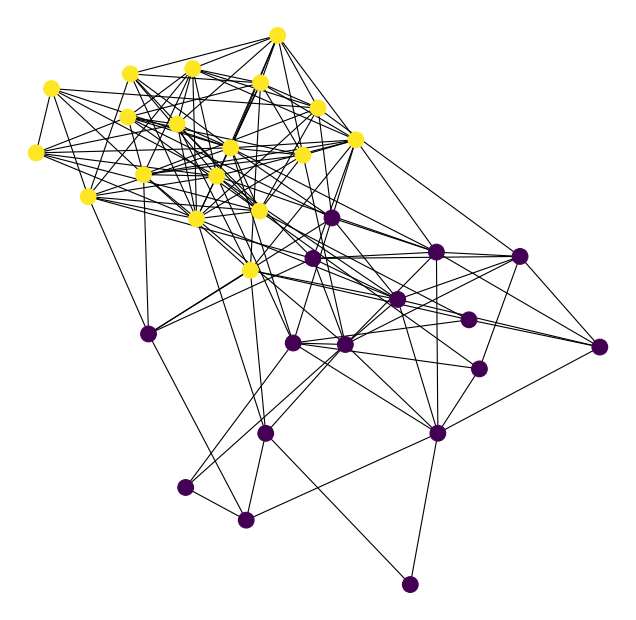

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10, 10), dpi=80)
nx.draw(G, ax=ax, node_color=communities, node_size=200)
fig.savefig('communities.png')

In [15]:
communities

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## Competition

In [16]:
import os
import pandas as pd 

In [17]:
files = {}
for entry in os.scandir('competition'):
    name = entry.path.split('\\')[1].split('.')[0]
    adjacency = np.loadtxt(entry, delimiter=',', dtype=float)
    files[name] = adjacency
    print(name)

D1-K=2
D1-UNC
D2-K=7
D2-UNC
D3-K=12
D3-UNC


### D1-K=2

In [18]:
%timeit bethe_hessian(files['D1-K=2'], k=2, verbose=False)

1.85 ms ± 643 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
d1k2 = bethe_hessian(files['D1-K=2'], k=2, verbose=False)

In [20]:
df = pd.DataFrame(d1k2+1)
df.index = np.arange(1, len(df)+1)
df.to_csv("competition_solutions/D1-K=2.csv", header=None)

### D1-UNC 

In [21]:
%timeit bethe_hessian(files['D1-UNC'], verbose=False)

<ipython-input-5-ba9dd784307f>:3: RuntimeWarning: Mean of empty slice.
  return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])
c:\users\micha\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


The slowest run took 7.78 times longer than the fastest. This could mean that an intermediate result is being cached.
86.1 ms ± 68.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
d1unc = bethe_hessian(files['D1-UNC'])

Assortative dimension detected: 14
Disassortative dimension detected: 0
k means converged after 5 iterations


In [23]:
df = pd.DataFrame(d1unc+1)
df.index = np.arange(1, len(df)+1)
df.to_csv("competition_solutions/D1-UNC.csv", header=None)

### D2-K=7
We change the t parameter so that the detected dimension is equal to the known number of communities

In [24]:
%timeit bethe_hessian(files['D2-K=7'], k=7, verbose=False, t=1.10)

5.36 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
d2k7 = bethe_hessian(files['D2-K=7'], k=7, t=1.10)

Assortative dimension detected: 6
Disassortative dimension detected: 1
k means converged after 6 iterations


In [26]:
df = pd.DataFrame(d2k7+1)
df.index = np.arange(1, len(df)+1)
df.to_csv("competition_solutions/D2-K=7.csv", header=None)

### D2-UNC

In [27]:
%timeit bethe_hessian(files['D2-UNC'], verbose=False)

<ipython-input-5-ba9dd784307f>:3: RuntimeWarning: Mean of empty slice.
  return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])


The slowest run took 30.65 times longer than the fastest. This could mean that an intermediate result is being cached.
555 ms ± 434 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
d2unc = bethe_hessian(files['D2-UNC'])

Assortative dimension detected: 15
Disassortative dimension detected: 0
k means converged after 2 iterations


In [38]:
df = pd.DataFrame(d2unc+1)
df.index = np.arange(1, len(df)+1)
df.to_csv("competition_solutions/D2-UNC.csv", header=None)

### D3-K=12

In [30]:
%timeit bethe_hessian(files['D3-K=12'], verbose=False, t=1.35)

<ipython-input-5-ba9dd784307f>:3: RuntimeWarning: Mean of empty slice.
  return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])


The slowest run took 8.60 times longer than the fastest. This could mean that an intermediate result is being cached.
92.1 ms ± 61.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
d3k12 = bethe_hessian(files['D3-K=12'], t=1.35)

Assortative dimension detected: 12
Disassortative dimension detected: 0
k means converged after 4 iterations


In [32]:
df = pd.DataFrame(d3k12+1)
df.index = np.arange(1, len(df)+1)
df.to_csv("competition_solutions/D3-K=12.csv", header=None)

### D3-UNC

In [33]:
%timeit bethe_hessian(files['D3-UNC'], verbose=False)

<ipython-input-5-ba9dd784307f>:3: RuntimeWarning: Mean of empty slice.
  return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])


8.96 ms ± 970 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
d3unc = bethe_hessian(files['D3-UNC'])

Assortative dimension detected: 9
Disassortative dimension detected: 0
k means converged after 2 iterations


In [35]:
df = pd.DataFrame(d3unc+1)
df.index = np.arange(1, len(df)+1)
df.to_csv("competition_solutions/D3-UNC.csv", header=None)